In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier, plot_tree
from comparers import ModelComparer, plot_decision_boundary
from util import constraint_matrix_to_rules, RuleClassifier, calc_ground_truth_constraints
from surrogate_tree import tree_to_constraint_matrix
import logging
import copy
from sklearn.datasets import make_classification, make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
logging.basicConfig(level=logging.ERROR)

# Make Task

In [4]:
# Source: https://gitlab.com/andsta/diro2c/-/blob/develop/show_decision_boundaries_running_ex.py

feature_names = np.array(['x1', 'x2'])
feature_precisions = [1, 1]

X, y = make_classification(n_samples=300, n_features=2, n_informative=1, n_redundant=0, n_classes=2,
                             random_state=2, n_clusters_per_class=1, class_sep=1.8, flip_y=0, scale=100)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

clf_a = DecisionTreeClassifier(random_state=1)
clf_a.fit(X_train, y_train)

X2 = copy.deepcopy(X)
y2 = copy.deepcopy(y)
y2_new = []
for x_0, y_0 in zip(X2, y2):
    if x_0[0] < 150 and x_0[0] > 0 and x_0[1] > -100 and x_0[1] < 100 and y_0 == 1:
        y2_new.append(0)
    elif x_0[0] < 0 and x_0[0] > -200 and x_0[1] >= 100 and y_0 == 0:
        y2_new.append(1)
    else:
        y2_new.append(y_0)

X2 = np.asarray(X2)
y2 = np.asarray(y2_new)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=1)

clf_b = DecisionTreeClassifier(random_state=1)
clf_b.fit(X2_train, y2_train)

X_explain = X_test
y_explain = y_test

with open('data/task.pickle', 'wb') as f:
    pickle.dump((clf_a, clf_b, X_explain, y_explain, feature_names, feature_precisions), f)

In [3]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X_explain, y_explain, feature_names, feature_precisions = pickle.load(f)

In [5]:
from sklearn.metrics import classification_report

In [8]:
print(classification_report(clf_a.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        37

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [9]:
print(classification_report(clf_b.predict(X2_test), y2_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [6]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

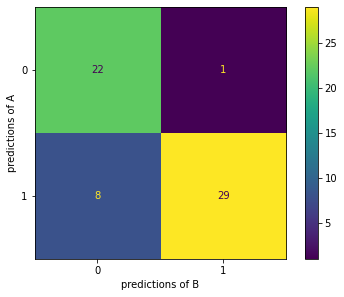

In [27]:
comparer.plot_confusion_matrix(X_explain)
plt.savefig('figures/running-example-cm.pdf')

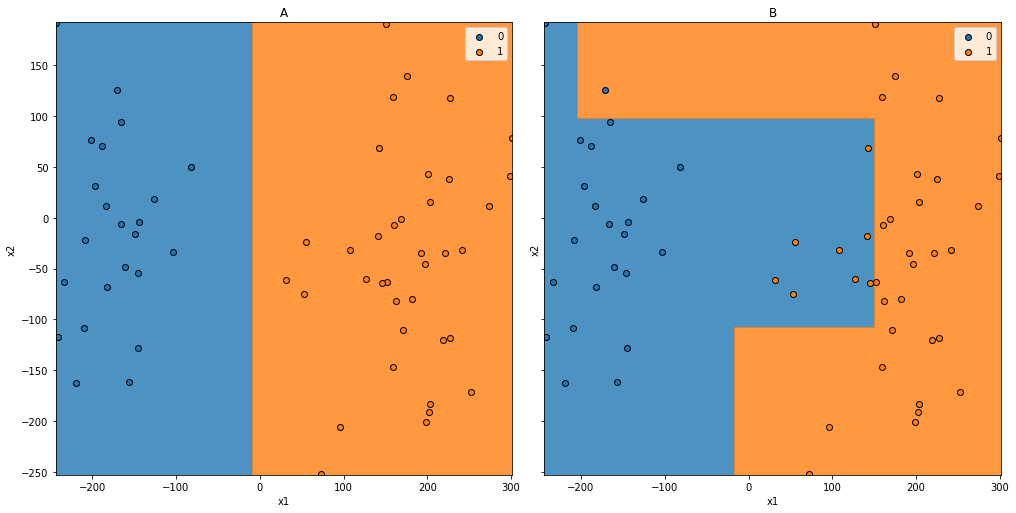

In [13]:
comparer.plot_individual_clf_decision_boundaries(X_explain, y_true=y_explain, kind='label')
plt.savefig('figures/running-example-decision-boundaries-indiv.pdf')

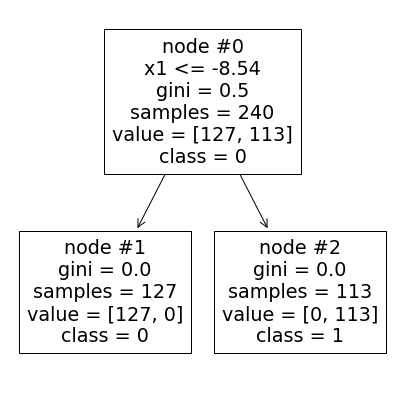

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_tree(comparer.clf_a, feature_names=comparer.feature_names, class_names=comparer.base_class_names, ax=ax, node_ids=True, precision=2);
plt.savefig('figures/running-example-tree-a.pdf', bbox_inches='tight')

Classifier A is a decision tree with just one node. It can be described with one simple rule.

In [4]:
constraints_a, class_occurences_a, labels_a, node_ids_a = tree_to_constraint_matrix(clf_a)
rules_a = constraint_matrix_to_rules(constraints_a, feature_names, precisions=feature_precisions)
rules_a = [rule for rule, label in zip(rules_a, labels_a) if label == 1 ]
rules_a

['x1 > -8.5']

In [5]:
boundary_x1_a = constraints_a[0, 0, 1]

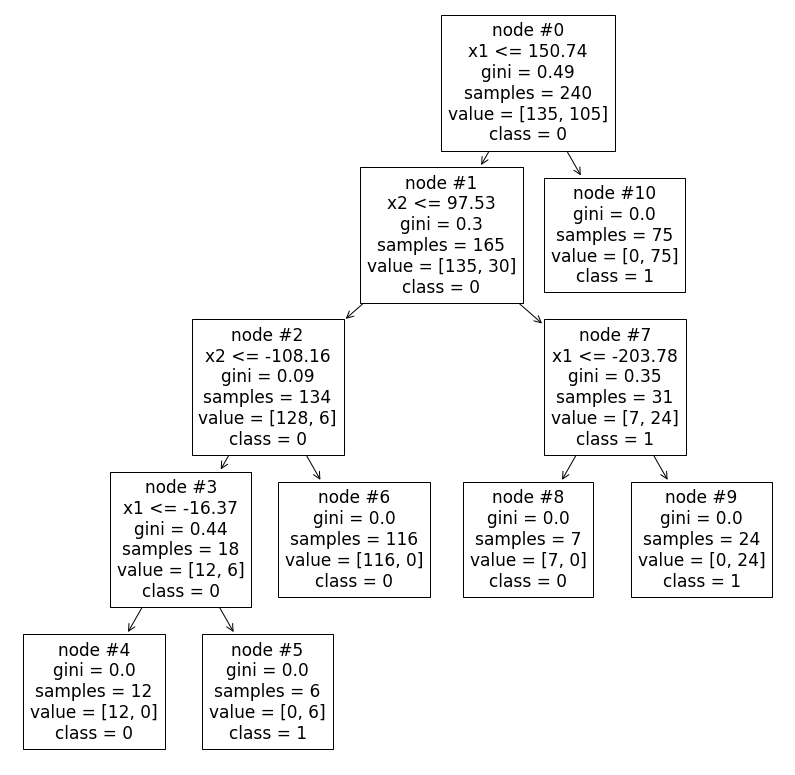

In [8]:
fig, ax = plt.subplots(figsize=(14, 14))
plot_tree(comparer.clf_b, feature_names=comparer.feature_names, class_names=comparer.base_class_names, ax=ax, node_ids=True, precision=2);
plt.savefig('figures/running-example-tree-b.pdf', bbox_inches='tight')

Whereas model B needs three rules:

In [6]:
constraints_b, class_occurences_b, labels_b, node_ids_b = tree_to_constraint_matrix(clf_b)
rules_b = constraint_matrix_to_rules(constraints_b, feature_names, precisions=feature_precisions)
rules_b = [rule for rule, label in zip(rules_b, labels_b) if label == 1 ]
rules_b

['-16.4 < x1 <= 150.7 and x2 <= -108.2',
 '-203.8 < x1 <= 150.7 and x2 > 97.5',
 'x1 > 150.7']

In [7]:
boundary_x1_b_left = constraints_b[3, 0, 1]
boundary_x1_b_middle = constraints_b[0, 0, 1]
boundary_x1_b_right = constraints_b[1, 0, 1]
boundary_x2_b_bottom = constraints_b[0, 1, 1]
boundary_x2_b_top = constraints_b[2, 1, 1]

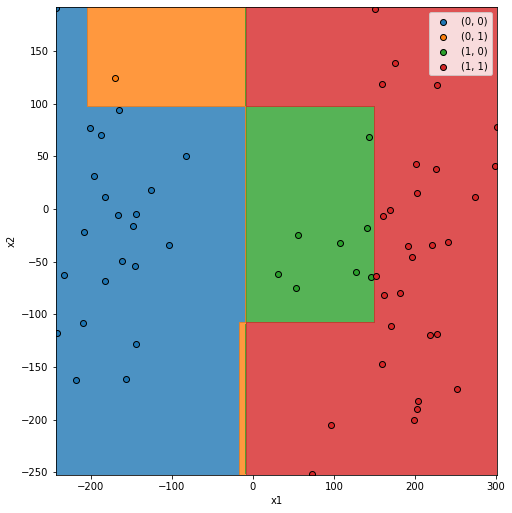

In [21]:
comparer.plot_decision_boundaries(X_explain)
plt.savefig('figures/running-example-diffclf.pdf')

In [17]:
constraints_01 = np.array([
    [
        [boundary_x1_b_left, boundary_x1_a],
        [boundary_x2_b_top, np.nan]
    ],
    [
        [boundary_x1_b_middle, boundary_x1_a],
        [np.nan, boundary_x2_b_bottom]
    ]
])
rules_01 = constraint_matrix_to_rules(constraints_01, feature_names, precisions=feature_precisions)
for rule_no, rule in enumerate(rules_01, 1):
    print(f'{rule_no}: {rule}')

1: -203.8 < x1 <= -8.5 and x2 > 97.5
2: -16.4 < x1 <= -8.5 and x2 <= -108.2


In [18]:
constraints_01

array([[[-203.77635193,   -8.54483223],
        [  97.53022003,           nan]],

       [[ -16.3683548 ,   -8.54483223],
        [          nan, -108.15950394]]])

In [16]:
constraints_10 = np.array([
    [
        [boundary_x1_a, boundary_x1_b_right],
        [boundary_x2_b_bottom, boundary_x2_b_top]
    ]
])
rules_10 = constraint_matrix_to_rules(constraints_10, feature_names, precisions=feature_precisions)
for rule_no, rule in enumerate(rules_10, 1):
    print(f'{rule_no}: {rule}')

1: -8.5 < x1 <= 150.7 and -108.2 < x2 <= 97.5


In [19]:
constraints_10

array([[[  -8.54483223,  150.74215698],
        [-108.15950394,   97.53022003]]])

# Test Set

In [7]:
X_explain_test, _ = make_blobs(n_samples=10000, centers=1, cluster_std=100, random_state=2)
y_explain_test = comparer.predict_mclass_diff(X_explain_test)
with open('data/test.pickle', 'wb') as f:
    pickle.dump((X_explain_test, y_explain_test), f)

In [11]:
with open('data/test.pickle', 'rb') as f:
    X_explain_test, y_explain_test = pickle.load(f)

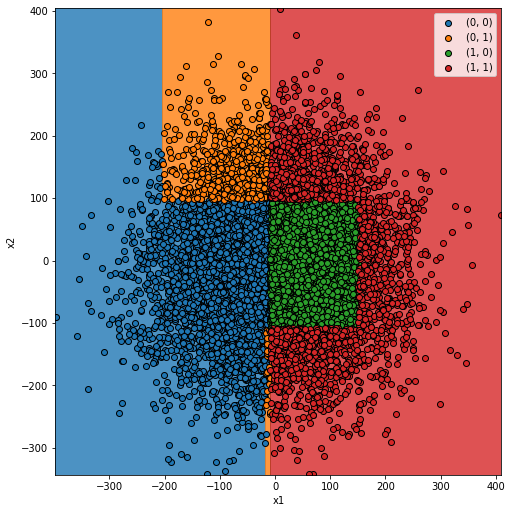

In [15]:
comparer.plot_decision_boundaries(X_explain_test)
plt.savefig('figures/running-scatter-test.pdf')

In [12]:
len(X_explain_test)

10000

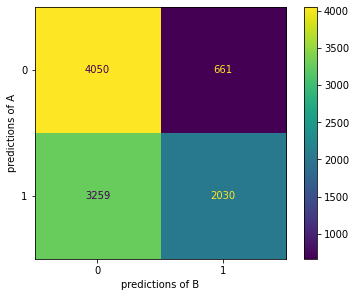

In [14]:
comparer.plot_confusion_matrix(X_explain_test)
plt.savefig('figures/running-cm-test.pdf')

# Further Plots

In [20]:
approaches = ['baseline', 'diro2c', 'shap']
metrics_per_approach = []
for approach in approaches:
    with open(f'data/fidelity-{approach}.pickle', 'rb') as f:
        metrics_per_approach.append((approach, pickle.load(f)))

In [26]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator

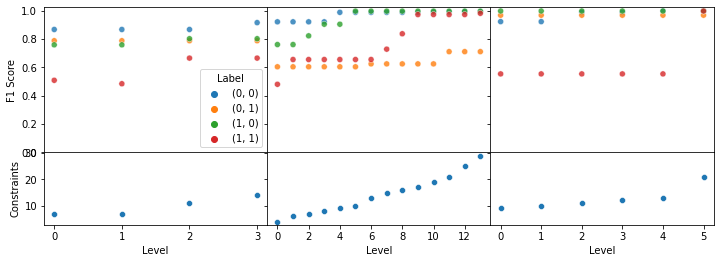

In [37]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3*4, 4), sharex='col', sharey='row', gridspec_kw={'height_ratios': [2,1]})
for (approach, (grouped_metrics, constraints)), axs_col in zip(metrics_per_approach, axs.T):
    sns.scatterplot(data=grouped_metrics, x='Level', y='F1 Score', hue='Label', alpha=0.8, ax=axs_col[0], legend=approach == 'baseline')
    sns.scatterplot(data=constraints, ax=axs_col[1])
    axs_col[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs_col[0].set_ylim((0, 1.025))
plt.subplots_adjust(wspace=.0, hspace=.0)
plt.savefig('figures/running-fidelity.pdf')

In [29]:
from explainers import plot_feature_dependence
import shap

In [30]:
with open('explanations/indiv.shap', 'rb') as f:
    shap_values = pickle.load(f)

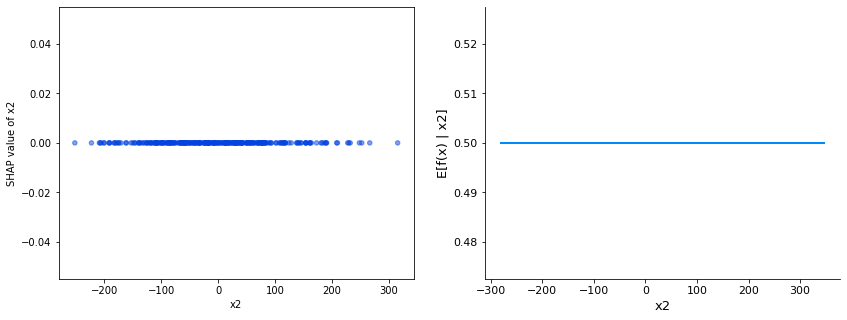

In [35]:
feature_idx, feature_name = comparer.check_feature('x2')
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, 'A.1'], feature_idx, alpha=0.5, ax=axs[0])
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.clf_a.predict_proba(X)[:, 1],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])

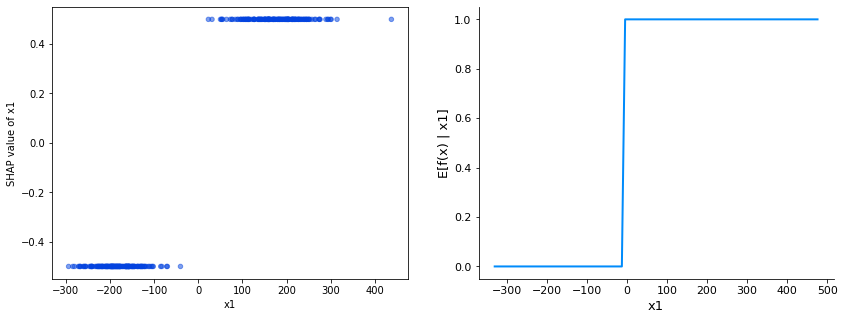

In [36]:
feature_idx, feature_name = comparer.check_feature('x1')
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, 'A.1'], feature_idx, alpha=0.5, ax=axs[0])
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.clf_a.predict_proba(X)[:, 1],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])